# VocalSound Embeddings Clustered using t-SNE and LAP Solver

This notebook demonstrates how to cluster the HeAR audio embeddings using t-SNE in 2-dimensional space, and then using LAP Solver to force them on a grid. Here we use the embeddings file 'vocalsound_processed_hear_embeddings.npy'. Check out the HeAR_embeddings.ipynb notebook to see the embedding generation pipeline.

The goal is to cluster these human health embeddings into a grid pattern, so that we can visualize and display patterns.

#### Here's a breakdown of the notebook's steps:

1.  **Load Embeddings:** Load the HeAR embeddings from disk

2.  **t-SNE Algorithm:**
    *   **Initial:** Run the t-SNE algorithm and visualize output on a manually set perplexity
    *   **Hyperparameter Search:** Test the t-SNE algorithm on different perplexities and visualize the clustering

3.  **Convert t-SNE to 2D Grid:** t-SNE outputs a cloud of clusters, but our visualization requires a 2D grid
    *   **LAP Solver Initial:** Runs the linear assignment problem (LAP) solver on our initial t-SNE output
    *   **Hyperparameter Search:** Runs the linear assignment problem (LAP) solver on our t-SNE outputs for various perplexities. Saves the best grid to disk

4.  **Convert to JSON:** Converts the grid data into a JSON file easily parsable by the frontend

**Note**: This notebook was heavily adapted from https://github.com/kylemcdonald/AudioNotebooks/blob/master/Fingerprints%20to%20t-SNE.ipynb and https://github.com/kylemcdonald/CloudToGrid. All credit to Kyle McDonald.

In [10]:
# @title Import Statements
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.spatial.distance import cdist
import csv
import json

# Use the standard 'scipy.optimize.linear_sum_assignment'
from scipy.optimize import linear_sum_assignment as lap_solver
import lap

## t-SNE Algorithm

Load the embeddings from disk

In [2]:
# @title Load the embeddings
EMBEDDINGS_FILE = 'vocalsound_processed_hear_embeddings.npy'
METADATA_FILE = 'vocalsound_processed_hear_metadata.csv'

embeddings = np.load(EMBEDDINGS_FILE) # Loads (20662, 1, 512)
embeddings = np.squeeze(embeddings, axis=1) # Removes the middle dimension
print(f"Loaded embeddings. Shape: {embeddings.shape}")

metadata_df = pd.read_csv(METADATA_FILE)
print(f"Loaded metadata. Shape: {metadata_df.shape}")

Loaded embeddings. Shape: (20662, 512)
Loaded metadata. Shape: (20662, 10)


### Run t-SNE Algorithm

#### Run t-SNE on manually set perplexity

In [5]:
# Range of 5 to 50 is standard, but bird sounds reference suggests a wider range (30-100 for large datasets)
# Refernce is Kyle McDonald's Audio Notebooks Fingerprints to t-SNE.ipynb
PERPLEXITY = 50
N_ITER = 3000
RANDOM_STATE = 42

# Define a new output file path
TSNE_FILE = os.path.join('t-SNE', 'vocalsound_processed_tsne_initial.csv')

print(f"\nTSNE Parameters: Perplexity={PERPLEXITY}, Iterations={N_ITER}")
print("Starting t-SNE calculation...")
start_time = time.time()

tsne = TSNE(
    n_components=2,
    perplexity=PERPLEXITY,
    max_iter=N_ITER,
    random_state=RANDOM_STATE,
    metric='cosine', # Cosine distance is often better for embeddings than Euclidean
    verbose=1,
    init='pca'
)

tsne_coordinates = tsne.fit_transform(embeddings)

# Normalize -- not necessary, but makes it easier to visualize results
tsne_coordinates -= tsne_coordinates.min(axis=0)
tsne_coordinates /= tsne_coordinates.max(axis=0)

end_time = time.time()
print(f"t-SNE calculation finished in: {end_time - start_time:.2f} seconds.")
print(f"t-SNE coordinates shape: {tsne_coordinates.shape}")

# Add the 2D t-SNE coordinates (x, y) to the DataFrame
metadata_df['tsne_x'] = tsne_coordinates[:, 0]
metadata_df['tsne_y'] = tsne_coordinates[:, 1]

final_columns = [
    'tsne_x',
    'tsne_y',
    'file_name',
    'sound_type',
    'id',
    'gender',
    'age',
    'native_language',
    'country',
    'health'
]

final_df = metadata_df[[col for col in final_columns]]

final_df.to_csv(TSNE_FILE, index=False)
print(f"Successfully saved final visualization data to: {TSNE_FILE}")
print("Final data structure (first 5 rows):")
print(final_df.head())


TSNE Parameters: Perplexity=50, Iterations=3000
Starting t-SNE calculation...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 20662 samples in 0.004s...
[t-SNE] Computed neighbors for 20662 samples in 6.044s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20662
[t-SNE] Computed conditional probabilities for sample 2000 / 20662
[t-SNE] Computed conditional probabilities for sample 3000 / 20662
[t-SNE] Computed conditional probabilities for sample 4000 / 20662
[t-SNE] Computed conditional probabilities for sample 5000 / 20662
[t-SNE] Computed conditional probabilities for sample 6000 / 20662
[t-SNE] Computed conditional probabilities for sample 7000 / 20662
[t-SNE] Computed conditional probabilities for sample 8000 / 20662
[t-SNE] Computed conditional probabilities for sample 9000 / 20662
[t-SNE] Computed conditional probabilities for sample 10000 / 20662
[t-SNE] Computed conditional probabilities for sample 11000 / 20662
[t-SNE] Computed conditional probabili

Load the data back from vocalsound_processed_tsne_data_initial.csv

In [7]:
TSNE_FILE = os.path.join('t-SNE', 'vocalsound_processed_tsne_initial.csv')
final_df = pd.read_csv(TSNE_FILE)
print(f"Loaded final data from: {TSNE_FILE}")
print(f"Data shape: {final_df.shape}")

Loaded final data from: t-SNE/vocalsound_processed_tsne_initial.csv
Data shape: (20662, 10)


First scatterplot initialization for t-SNE

/var/folders/pn/7ysbjdfn4h3ddgnl7ymjpf5r0000gn/T/ipykernel_82825/1991617804.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


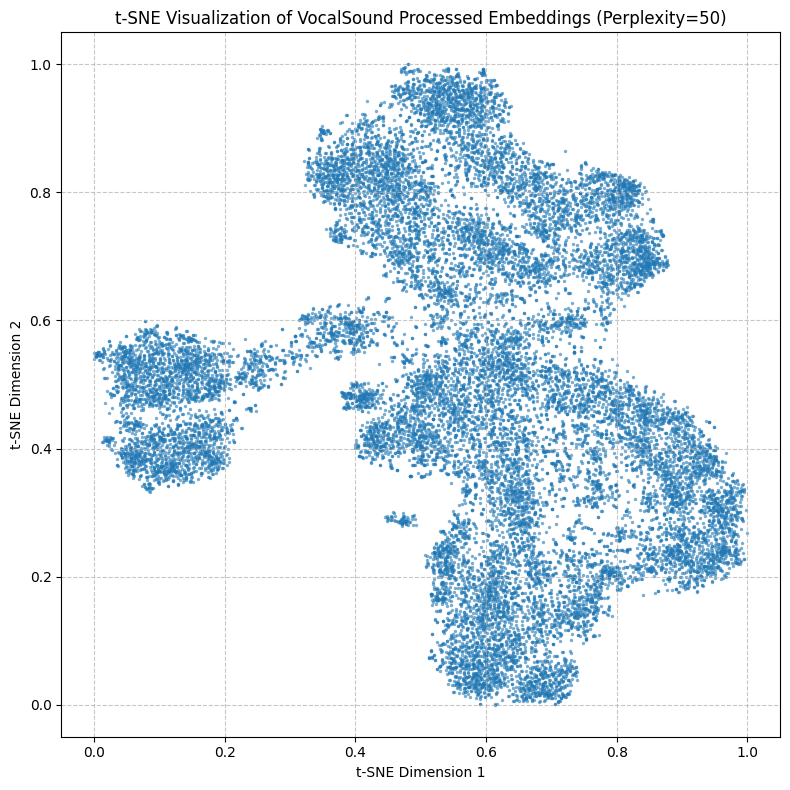

In [11]:
PERPLEXITY = 50

plt.figure(figsize=(8, 8))

sns.scatterplot(
    x='tsne_x',
    y='tsne_y',
    data=final_df,
    s=6,
    alpha=0.6,
    linewidth=0,
    palette='deep'
)

plt.title(f"t-SNE Visualization of VocalSound Processed Embeddings (Perplexity={PERPLEXITY})", fontsize=12)
plt.xlabel("t-SNE Dimension 1", fontsize=10)
plt.ylabel("t-SNE Dimension 2", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

Highlight the different attributes in the scatterplot

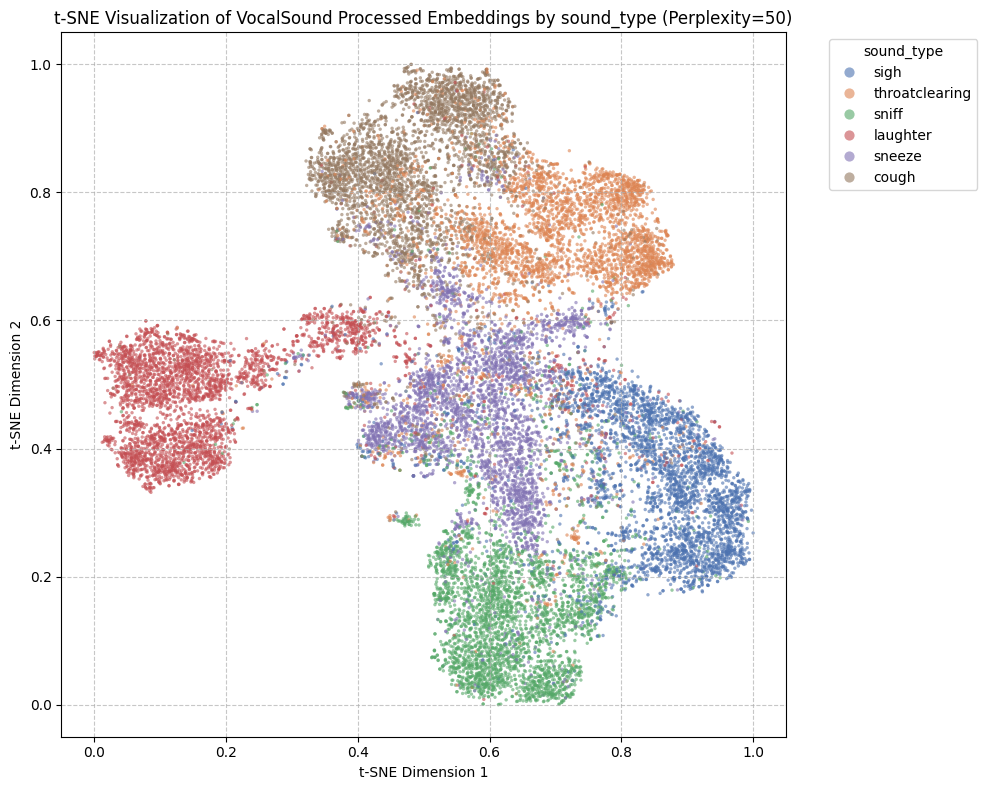

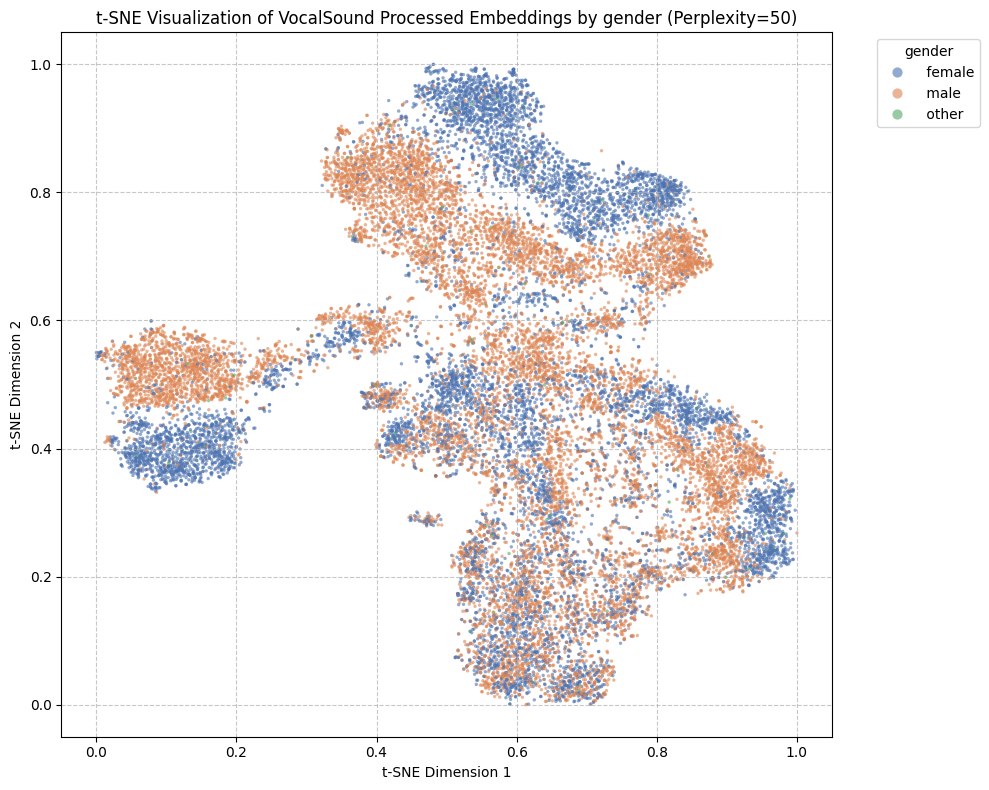

In [14]:
filters = ['sound_type', 'gender']

for filter in filters:
    plt.figure(figsize=(10, 8))

    sns.scatterplot(
        x='tsne_x',
        y='tsne_y',
        hue=filter,
        data=final_df,
        s=6,
        alpha=0.6,
        linewidth=0,
        palette='deep'
    )

    plt.title(f"t-SNE Visualization of VocalSound Processed Embeddings by {filter} (Perplexity={PERPLEXITY})", fontsize=12)
    plt.xlabel("t-SNE Dimension 1", fontsize=10)
    plt.ylabel("t-SNE Dimension 2", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title=filter, bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=3.0)
    plt.tight_layout()

    plt.show()

#### Hyperparameter Search

Now, we go through a range of different perplexity values. We'll save plots, and then manually inspect them to observe which perplexity value most clustered similar attributes correctly.

Recall that perplexity is loosely interpreted as the number of nearest neighbors of a point. Since N ~ 20,000, we expect there to be a relatively high level of neighbors, so that our perplexity range will be skewed large.

In [16]:
perplexities = [15, 30, 50, 100, 200, 400]
N_ITER = 3000
RANDOM_STATE = 42 # So that re-running yields same plot

for p in perplexities:
  TSNE_FILE = os.path.join('t-SNE', 'processed', f'vocalsound_processed_tsne_{p}.csv')

  print(f"\nTSNE Parameters: Perplexity={p}")
  start_time = time.time()

  tsne = TSNE(
      n_components=2,
      perplexity=p,
      max_iter=N_ITER,
      random_state=RANDOM_STATE,
      metric='cosine',
      verbose=1,
      init='pca'
  )

  tsne_coordinates = tsne.fit_transform(embeddings)

  # Normalize -- not necessary, but makes it easier to visualize results
  tsne_coordinates -= tsne_coordinates.min(axis=0)
  tsne_coordinates /= tsne_coordinates.max(axis=0)

  end_time = time.time()
  print(f"t-SNE calculation finished in: {end_time - start_time:.2f} seconds.")

  # Add the 2D t-SNE coordinates (x, y) to the DataFrame
  metadata_df['tsne_x'] = tsne_coordinates[:, 0]
  metadata_df['tsne_y'] = tsne_coordinates[:, 1]

  final_columns = [
      'tsne_x',
      'tsne_y',
      'file_name',
      'sound_type',
      'id',
      'gender',
      'age',
      'native_language',
      'country',
      'health'
  ]

  final_df = metadata_df[[col for col in final_columns]]

  final_df.to_csv(TSNE_FILE, index=False)
  print(f"Successfully saved t-SNE data to: {TSNE_FILE}")


TSNE Parameters: Perplexity=15
[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 20662 samples in 0.003s...
[t-SNE] Computed neighbors for 20662 samples in 5.982s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20662
[t-SNE] Computed conditional probabilities for sample 2000 / 20662
[t-SNE] Computed conditional probabilities for sample 3000 / 20662
[t-SNE] Computed conditional probabilities for sample 4000 / 20662
[t-SNE] Computed conditional probabilities for sample 5000 / 20662
[t-SNE] Computed conditional probabilities for sample 6000 / 20662
[t-SNE] Computed conditional probabilities for sample 7000 / 20662
[t-SNE] Computed conditional probabilities for sample 8000 / 20662
[t-SNE] Computed conditional probabilities for sample 9000 / 20662
[t-SNE] Computed conditional probabilities for sample 10000 / 20662
[t-SNE] Computed conditional probabilities for sample 11000 / 20662
[t-SNE] Computed conditional probabilities for sample 12000 / 20662
[t-SNE] Computed c

Load and plot t-SNE visualizations for each perplexity

In [23]:
for p in perplexities:
    TSNE_FILE = os.path.join('t-SNE', 'processed', f'vocalsound_processed_tsne_{p}.csv')
    final_df = pd.read_csv(TSNE_FILE)
    print(f"Loaded final data from: {TSNE_FILE}")

    OUTPUT_SUBDIR = os.path.join('plots', 'processed', f'perplexity-{p}')
    os.makedirs(OUTPUT_SUBDIR, exist_ok=True)
    PLOT_FILE = f'tsne_visualization_{p}.png'

    plt.figure(figsize=(8, 8))

    sns.scatterplot(
        x='tsne_x',
        y='tsne_y',
        data=final_df,
        s=6,
        alpha=0.6,
        linewidth=0,
    )

    plt.title(f"t-SNE Visualization of VocalSound Processed Embeddings (Perplexity={p})", fontsize=12)
    plt.xlabel("t-SNE Dimension 1", fontsize=10)
    plt.ylabel("t-SNE Dimension 2", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    full_plot_path = os.path.join(OUTPUT_SUBDIR, PLOT_FILE)
    plt.savefig(full_plot_path, dpi=300)
    plt.close() # Don't print graph to output
    print(f"Plot saved to: {PLOT_FILE}")

Loaded final data from: t-SNE/processed/vocalsound_processed_tsne_15.csv
Plot saved to: tsne_visualization_15.png
Loaded final data from: t-SNE/processed/vocalsound_processed_tsne_30.csv
Plot saved to: tsne_visualization_30.png
Loaded final data from: t-SNE/processed/vocalsound_processed_tsne_50.csv
Plot saved to: tsne_visualization_50.png
Loaded final data from: t-SNE/processed/vocalsound_processed_tsne_100.csv
Plot saved to: tsne_visualization_100.png
Loaded final data from: t-SNE/processed/vocalsound_processed_tsne_200.csv
Plot saved to: tsne_visualization_200.png
Loaded final data from: t-SNE/processed/vocalsound_processed_tsne_400.csv
Plot saved to: tsne_visualization_400.png


#### Visualizations

To see how well t-SNE performs for various perplexities, let's plot the points based on their attributes (sound type, gender), and see if they cluster well.

In [25]:
filters = ['sound_type', 'gender']

for p in perplexities:
  for filter in filters:

      TSNE_FILE = os.path.join('t-SNE', 'processed', f'vocalsound_processed_tsne_{p}.csv')
      final_df = pd.read_csv(TSNE_FILE)
      print(f"Loaded final data from: {TSNE_FILE}")

      PLOT_FILE = f'tsne_visualization_{p}_{filter}.png'

      plt.figure(figsize=(10, 8))

      sns.scatterplot(
          x='tsne_x',
          y='tsne_y',
          hue=filter,
          data=final_df,
          s=6,
          alpha=0.6,
          linewidth=0,
          palette='deep'
      )

      plt.title(f"t-SNE Visualization of VocalSound Processed Embeddings by {filter} (Perplexity={p})", fontsize=12)
      plt.xlabel("t-SNE Dimension 1", fontsize=10)
      plt.ylabel("t-SNE Dimension 2", fontsize=10)
      plt.grid(True, linestyle='--', alpha=0.7)
      plt.legend(title=filter, bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=3.0)
      plt.tight_layout()

      plt.savefig(os.path.join('plots', 'processed', f'perplexity-{p}', PLOT_FILE), dpi=300)
      plt.close()
      print(f"Plot saved to: {PLOT_FILE}")

Loaded final data from: t-SNE/processed/vocalsound_processed_tsne_15.csv
Plot saved to: tsne_visualization_15_sound_type.png
Loaded final data from: t-SNE/processed/vocalsound_processed_tsne_15.csv
Plot saved to: tsne_visualization_15_gender.png
Loaded final data from: t-SNE/processed/vocalsound_processed_tsne_30.csv
Plot saved to: tsne_visualization_30_sound_type.png
Loaded final data from: t-SNE/processed/vocalsound_processed_tsne_30.csv
Plot saved to: tsne_visualization_30_gender.png
Loaded final data from: t-SNE/processed/vocalsound_processed_tsne_50.csv
Plot saved to: tsne_visualization_50_sound_type.png
Loaded final data from: t-SNE/processed/vocalsound_processed_tsne_50.csv
Plot saved to: tsne_visualization_50_gender.png
Loaded final data from: t-SNE/processed/vocalsound_processed_tsne_100.csv
Plot saved to: tsne_visualization_100_sound_type.png
Loaded final data from: t-SNE/processed/vocalsound_processed_tsne_100.csv
Plot saved to: tsne_visualization_100_gender.png
Loaded final

### Convert the t-SNE embeddings into 2D grid

#### Run LAP Solver on Initial t-SNE

Load the initial t-SNE embeddings from disk

In [3]:
# @title Load the embeddings
EMBEDDINGS_FILE = 'vocalsound_processed_hear_embeddings.npy'
METADATA_FILE = 'vocalsound_processed_hear_metadata.csv'

embeddings = np.load(EMBEDDINGS_FILE) # Loads (20662, 1, 512)
embeddings = np.squeeze(embeddings, axis=1) # Removes the middle dimension
print(f"Loaded embeddings. Shape: {embeddings.shape}")

metadata_df = pd.read_csv(METADATA_FILE)
print(f"Loaded metadata. Shape: {metadata_df.shape}")

Loaded embeddings. Shape: (20662, 512)
Loaded metadata. Shape: (20662, 10)


In [4]:
TSNE_FILE = os.path.join('t-SNE', 'vocalsound_processed_tsne_initial.csv')
final_df = pd.read_csv(TSNE_FILE)
print(f"Loaded final t-SNE data from: {TSNE_FILE}")
print(f"Data shape: {final_df.shape}")

data2d = final_df[['tsne_x', 'tsne_y']].values

Loaded final t-SNE data from: t-SNE/vocalsound_processed_tsne_initial.csv
Data shape: (20662, 10)


Display a blank grid of appropriate length

t-SNE shape: (20662, 2)
Grid shape: (20736, 2)


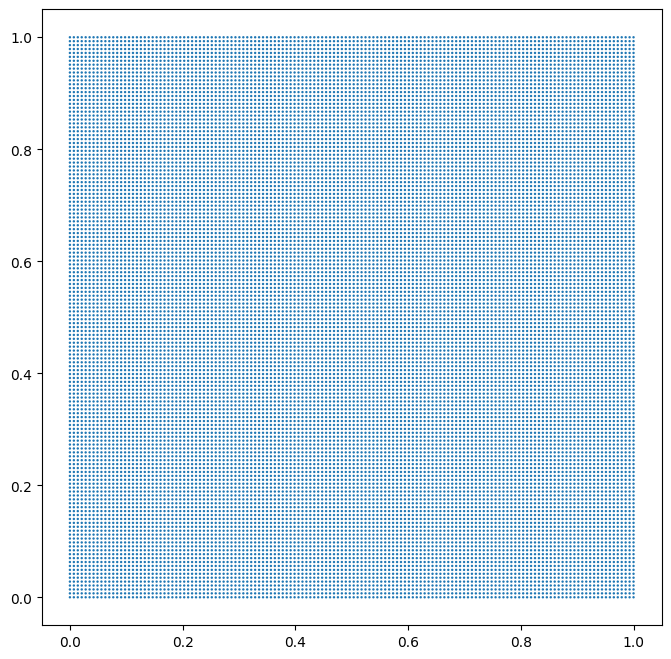

In [5]:
num_data = len(data2d)
side = math.ceil(np.sqrt(num_data))

xv, yv = np.meshgrid(np.linspace(0, 1, side), np.linspace(0, 1, side))
grid = np.dstack((xv, yv)).reshape(-1, 2)

print(f"t-SNE shape: {data2d.shape}")
print(f"Grid shape: {grid.shape}")

plt.figure(figsize=(8,8))
plt.scatter(grid[:,0], grid[:,1], edgecolors='none', marker='o', s=3)
plt.show()

# Add the t-SNE coordinates to metadata_df for later use (if not already there)
metadata_df['tsne_x'] = data2d[:, 0]
metadata_df['tsne_y'] = data2d[:, 1]
final_df = metadata_df.copy()

Run the LAP Solver Algorithm to transform the 2D t-SNE onto a grid

**Cost**: The (squared Euclidean) distance from every grid point to every t-SNE point
- Cost[i, j] = dist from point i to grid j = dist from data2d[i] to grid[j]
- M - number of points in grid, N - number of data points --> Cost Matrix (N, M)

In [34]:
# Calculate the cost matrix
print("\nCalculating Cost Matrix...")
cost = cdist(data2d, grid, 'sqeuclidean') # cost matrix must be (N, M), where N <= M

# Solve the Linear Assignment Problem (using scipy.optimize.linear_sum_assignment)
print("Solving Linear Assignment Problem (LAP)...")
start_time = time.time()

# Solver finds assignment that minimizes the total cost
row_assigns, col_assigns = lap_solver(cost)
end_time = time.time()
print(f"LAP solved in: {end_time - start_time:.2f} seconds.")

# Create the new DataFrame with the mapped grid coordinates
# col_assigns tells us which grid index (column) was assigned to which data index (row).
grid_mapped_coords = grid[col_assigns]

# Add the Grid Coordinates to the Final DataFrame
# Map the assigned grid coordinates directly back to the original final_df.
final_df['grid_x'] = np.nan
final_df['grid_y'] = np.nan
# Row_assigns should be [0, 1, 2, ..., N-1].
final_df.loc[row_assigns, ['grid_x', 'grid_y']] = grid_mapped_coords

print("New columns 'grid_x' and 'grid_y' added to final_df.")


Calculating Cost Matrix...
Solving Linear Assignment Problem (LAP)...
LAP solved in: 1394.65 seconds.
New columns 'grid_x' and 'grid_y' added to final_df.


Displays the 2D grid by sound type and gender

Plot saved to: tsne_visualization_400_gender.png


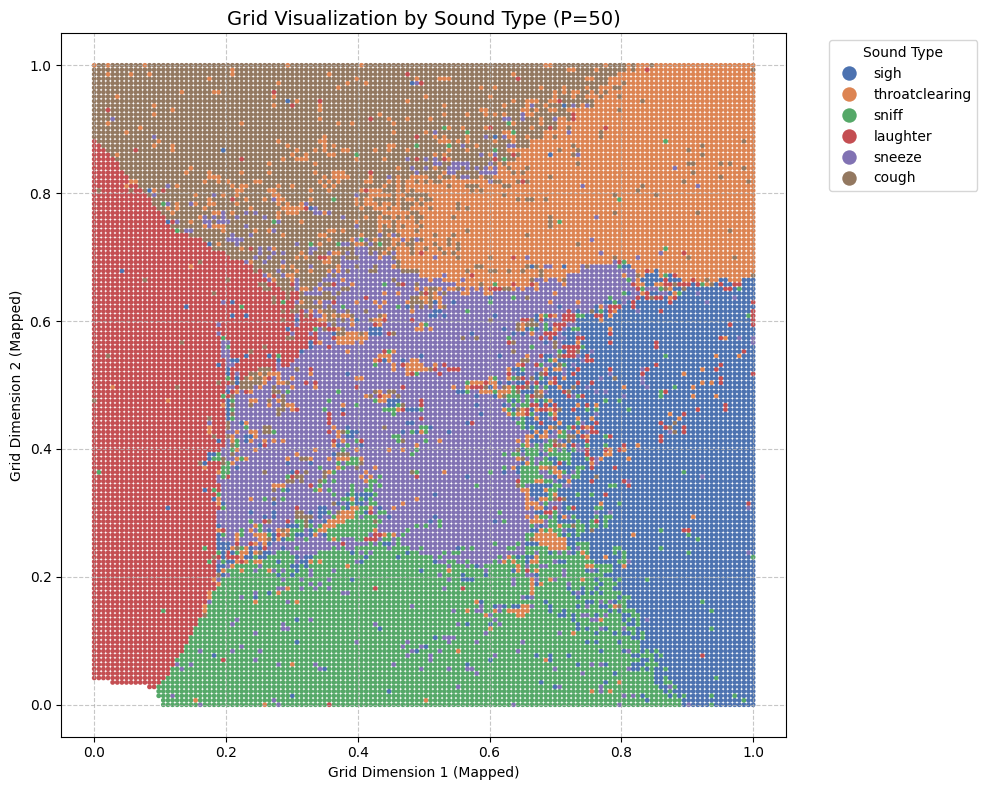

Plot saved to: tsne_visualization_400_gender.png


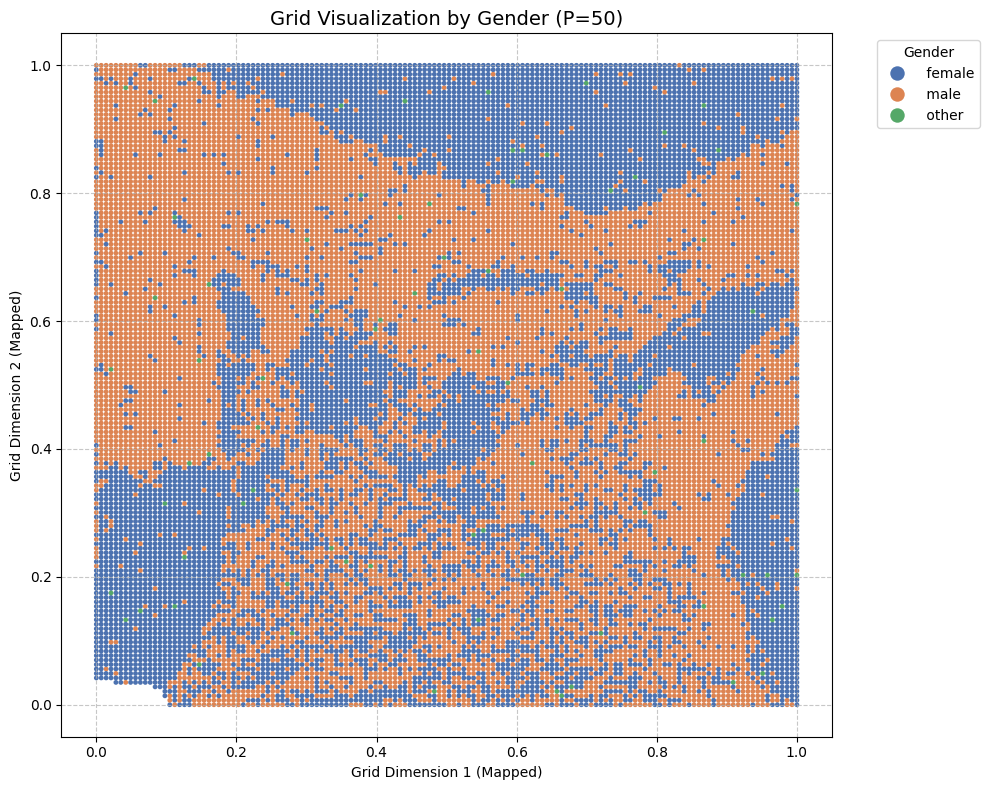

In [35]:
filters = ['sound_type', 'gender']

for filter in filters:
    plot_title_filter = filter.replace('_', ' ').title()

    plt.figure(figsize=(10, 8))

    # Plot grid_x, grid_y instead of tsne_x/tsne_y
    sns.scatterplot(
        x='grid_x',
        y='grid_y',
        hue=filter,
        data=final_df,
        s=12,
        alpha=1.0,
        linewidth=0,
        palette='deep'
    )

    plt.title(f"Grid Visualization by {plot_title_filter} (P={PERPLEXITY})", fontsize=14)
    plt.xlabel("Grid Dimension 1 (Mapped)", fontsize=10)
    plt.ylabel("Grid Dimension 2 (Mapped)", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title=plot_title_filter, bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=3.0)
    plt.tight_layout()

    print(f"Plot saved to: {PLOT_FILE}")
    plt.show()

#### Hyperparameter Search: Test grid clustering w/ different perplexities

In [ ]:
# @title Test grid clustering w/ different perplexities
perplexities = [15, 30, 50, 100, 200, 400]

for p in perplexities:
    TSNE_INPUT_FILE = os.path.join('t-SNE', 'processed', f'vocalsound_processed_tsne_{p}.csv')
    BASE_PLOTS_DIR = os.path.join('plots', 'processed', 'grid_visualization', f'p{p}')
    os.makedirs(BASE_PLOTS_DIR, exist_ok=True)
    FILTERS = ['sound_type', 'gender']

    print(f"Perplexity = {p}")

    current_df = pd.read_csv(TSNE_INPUT_FILE)
    data2d = current_df[['tsne_x', 'tsne_y']].values
    print(f"Loaded pre-computed t-SNE data from: {TSNE_INPUT_FILE}")
    print(f"t-SNE data shape: {data2d.shape}")

    num_data = len(data2d)
    side = math.ceil(np.sqrt(num_data)) # For 20622, side is 144

    xv, yv = np.meshgrid(np.linspace(0, 1, side), np.linspace(0, 1, side))
    grid = np.dstack((xv, yv)).reshape(-1, 2)

    print(f"Calculating Cost Matrix")

    # Cost[i, j] = distance from data2d[i] to grid[j]
    # Shape: (N, M) where N=len(data2d), M=len(grid)
    cost = cdist(data2d, grid, 'sqeuclidean')

    print("Solving Linear Assignment Problem (LAP)")
    start_time = time.time()

    row_assigns, col_assigns = lap_solver(cost)
    end_time = time.time()

    print(f"LAP solved in: {end_time - start_time:.2f} seconds.")

    grid_mapped_coords = grid[col_assigns]

    # Add the Grid Coordinates to the DataFrame
    current_df['grid_x'] = np.nan
    current_df['grid_y'] = np.nan
    current_df.loc[row_assigns, ['grid_x', 'grid_y']] = grid_mapped_coords

    OUTPUT_DATA_FILE = os.path.join('t-SNE', 'processed', 'grid', f'vocalsound_grid_p{p}.csv')
    current_df.to_csv(OUTPUT_DATA_FILE, index=False)
    print(f"Successfully saved mapped grid data to: {OUTPUT_DATA_FILE}")

    for filter_col in FILTERS:
        PLOT_FILE = f'grid_visualization_P{p}_{filter_col}.png'
        plot_title_filter = filter_col.replace('_', ' ').title()

        plt.figure(figsize=(10, 8))

        sns.scatterplot(
            x='grid_x',
            y='grid_y',
            hue=filter_col,
            data=current_df,
            s=12,
            alpha=1.0,
            linewidth=0,
            palette='deep'
        )

        plt.title(f"Grid by {plot_title_filter} | P={p}", fontsize=14)
        plt.xlabel("Grid Dimension 1 (Mapped)", fontsize=10)
        plt.ylabel("Grid Dimension 2 (Mapped)", fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(title=plot_title_filter, bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=3.0)
        plt.tight_layout()

        plt.savefig(os.path.join(BASE_PLOTS_DIR, PLOT_FILE), dpi=300)
        plt.close()
        print(f"  Saved plot: {os.path.join(BASE_PLOTS_DIR, PLOT_FILE)}")

Perplexity = 50
Loaded pre-computed t-SNE data from: t-SNE/processed/vocalsound_processed_tsne_50.csv
t-SNE data shape: (20662, 2)
Calculating Cost Matrix
Solving Linear Assignment Problem (LAP)
LAP solved in: 1353.27 seconds.
Successfully saved mapped grid data to: t-SNE/processed/grid/vocalsound_grid_p50.csv
  Saved plot: plots/processed/grid_visualization/p50/grid_visualization_P50_sound_type.png
  Saved plot: plots/processed/grid_visualization/p50/grid_visualization_P50_gender.png
Perplexity = 100
Loaded pre-computed t-SNE data from: t-SNE/processed/vocalsound_processed_tsne_100.csv
t-SNE data shape: (20662, 2)
Calculating Cost Matrix
Solving Linear Assignment Problem (LAP)
LAP solved in: 1549.31 seconds.
Successfully saved mapped grid data to: t-SNE/processed/grid/vocalsound_grid_p100.csv
  Saved plot: plots/processed/grid_visualization/p100/grid_visualization_P100_sound_type.png
  Saved plot: plots/processed/grid_visualization/p100/grid_visualization_P100_gender.png
Perplexity = 

Right now the `grid_x` and `grid_y` coordinates in `t-SNE/processed/vocalsound_grid_p50.csv` are in `(0, 1)`. However, the frontend wants indices from `[0, 1, ..., 143]`

Convert `grid_x` and `grid_y` to 0-based indices

In [9]:
# @title Convert the x_grid and y_grid attributes to integer-based indices for frontend
perplexities = [15, 30, 50, 100, 200, 400]
T_SNE_DIR = os.path.join('t-SNE', 'processed', 'grid')

OUTPUT_GRID_INDEX_DIR = os.path.join(T_SNE_DIR, 'index')
os.makedirs(OUTPUT_GRID_INDEX_DIR, exist_ok=True)

for p in perplexities:
    INPUT_DATA_FILE = os.path.join(T_SNE_DIR, f'vocalsound_grid_p{p}.csv')

    df = pd.read_csv(INPUT_DATA_FILE)
    print(f"Loaded file: {INPUT_DATA_FILE}")

    num_data = len(df)
    side = math.ceil(np.sqrt(num_data))

    # original grid values were created with linspace(0, 1, side) --> dist between grid points is 1 / (side - 1)
    scaling_factor = side - 1
    df['grid_x_idx'] = np.round(df['grid_x'] * scaling_factor).astype(int)
    df['grid_y_idx'] = np.round(df['grid_y'] * scaling_factor).astype(int)

    df = df.drop(columns=['grid_x', 'grid_y'])
    df = df.rename(columns={'grid_x_idx': 'grid_x', 'grid_y_idx': 'grid_y'})

    OUTPUT_FILE_NAME = f'vocalsound_grid_index_p{p}.csv'
    FINAL_OUTPUT_PATH = os.path.join(OUTPUT_GRID_INDEX_DIR, OUTPUT_FILE_NAME)

    df.to_csv(FINAL_OUTPUT_PATH, index=False)

Loaded file: t-SNE/processed/grid/vocalsound_grid_p15.csv
Loaded file: t-SNE/processed/grid/vocalsound_grid_p30.csv
Loaded file: t-SNE/processed/grid/vocalsound_grid_p50.csv
Loaded file: t-SNE/processed/grid/vocalsound_grid_p100.csv
Loaded file: t-SNE/processed/grid/vocalsound_grid_p200.csv
Loaded file: t-SNE/processed/grid/vocalsound_grid_p400.csv


### Convert the grid metadata to JSON for the frontend

A perplexity of 50 appears to look the cleanest. Clearly the classification is not perfect, but this is not necessarily due to our algorithm. The VocalSound dataset is messy and often mislabeled. Our focus is not on classification, so we'll stick with perplexity = 50

In [11]:
# Convert OUR choice for metadata: vocalsound_grid_index_p100.csv" into a JSON for the frontend
csv_file = "vocalsound_grid_index_p50.csv"
path = os.path.join("t-SNE", "processed", "grid", "index", csv_file)
json_file = "vocalsound_processed_grid_index_p50.json"

data_dict = {}

with open(path, newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        key = f"{row['grid_x']}_{row['grid_y']}"
        data_dict[key] = {
            "id": row["id"].capitalize(),
            "file_name": row["file_name"],
            "sound_type": row["sound_type"].capitalize(),
            "gender": row["gender"][1:].capitalize(),
            "age": row["age"],
            "native_language": row["country"][1:], # Note: These got swapped
            "country": row["native_language"][1:],
            "health": row["health"][1:].capitalize()
        }

with open(json_file, "w") as f:
    json.dump(data_dict, f, indent=2)